In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('sample_data/new_data4.csv')

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)  
for col in string_columns: 
    df[col] = df[col].str.lower().str.replace(' ', '_') 

In [4]:
rows_to_drop = df[df['ценна_доллар']<12000].index
df.drop(rows_to_drop, inplace=True)

In [5]:
# plt.figure(figsize=(6, 4))

# sns.histplot(df['ценна_доллар'], bins=40, color='black', alpha=1)
# plt.ylabel('Frequency')
# plt.xlabel('Price')
# plt.title('Distribution of prices')

# plt.show()

In [6]:
# plt.figure(figsize=(6, 4))

# # Plot the histogram
# sns.histplot(df['ценна_доллар'], bins=40, color='black', alpha=1)

# # Add a vertical line at a specific value, for example, mean
# plt.axvline(x=df['ценна_доллар'].mean(), color='red', linestyle='--', label='Mean')

# # Labeling and title
# plt.ylabel('Frequency')
# plt.xlabel('Price')
# plt.title('Distribution of prices')

# # Show legend
# plt.legend()

# # Show the plot
# plt.show()

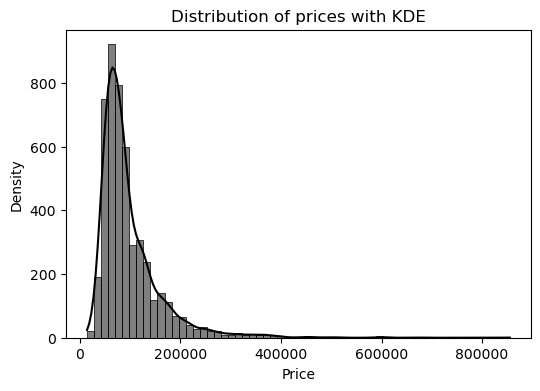

In [7]:
plt.figure(figsize=(6, 4))

sns.histplot(df['ценна_доллар'], bins=60, color='black', alpha=0.5, kde=True)

plt.ylabel('Density')
plt.xlabel('Price')
plt.title('Distribution of prices with KDE')


plt.show()

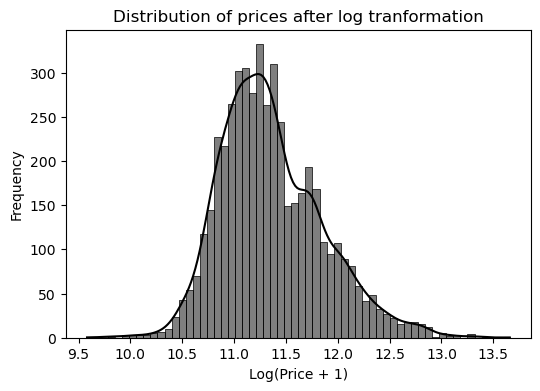

In [8]:
log_price = np.log1p(df['ценна_доллар'])

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=60, color='black', alpha=0.5, kde=True)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()


In [9]:
np.random.seed(2)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train['ценна_доллар'].values
y_val_orig = df_val['ценна_доллар'].values
y_test_orig = df_test['ценна_доллар'].values

y_train = np.log1p(df_train['ценна_доллар'].values)
y_val = np.log1p(df_val['ценна_доллар'].values)
y_test = np.log1p(df_test['ценна_доллар'].values)

del df_train['ценна_доллар']
del df_val['ценна_доллар']
del df_test['ценна_доллар']

In [10]:
base = ['комнаты', 'площадь', 'отопление', 'высота_потолков', 'красная_книга']

In [11]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2024 - df['год']
    features.append('age')
    
    features.append('общий_этаж')
    
    features.append('lat')
    features.append('lon')
    features.append('красная_книга')
    features.append('охрана')
    features.append('балкон')
    features.append('газ')
    
    features.append('видеонаблюдение')
    features.append('решетки_на_окнах')
    features.append('сигнализация')
    features.append('технический_паспорт')
    
    for v in ['монолитный', 'кирпичный', 'панельный']:
        feature = 'is_type_%s' % v
        df[feature] = (df['материал'] == v).astype(int)
        features.append(feature)
        
    for v in ['раздельный', 'совмещенный', '2_с/у_и_более']:
        feature = 'is_type_%s' % v
        df[feature] = (df['санузел'] == v).astype(int)
        features.append(feature)
        
    for v in ['элитка', 'индивид._планировка', '105_серия', '106_серия', '104_серия', 'хрущевка', '108_серия', 'сталинка', 'малосемейка']:
        feature = 'is_type_%s' % v
        df[feature] = (df['серия'] == v).astype(int)
        features.append(feature)
    
    for v in ['собственник', 'агент']:
        feature = 'is_typepr_%s' % v
        df[feature] = (df['тип_предложения'] == v).astype(int)
        features.append(feature)
    
    for v in ['евроремонт', 'под_самоотделку_(псо)', 'хорошее', 'среднее', 'не_достроено']:
        feature = 'is_remont_%s' % v
        df[feature] = (df['состояние'] == v).astype(int)
        features.append(feature)
        
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [13]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)
X_test = prepare_X(df_test)

XGBoost Validation - MSE: 0.019490854516941145, MAE: 0.10116678636933417, RMSE: 0.13960965051507415, MAPE: 0.8833701164460932
XGBoost Test - MSE: 0.024764707642840382, MAE: 0.10265399877122075, RMSE: 0.15736806424062152, MAPE: 0.8980102767873539


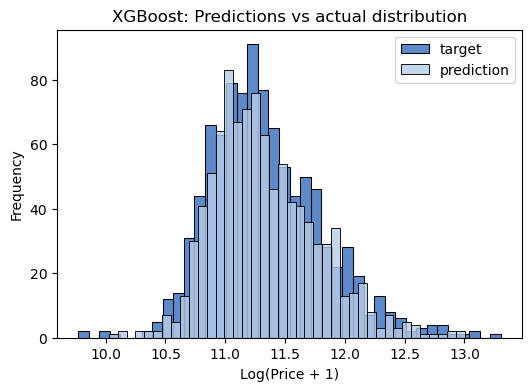

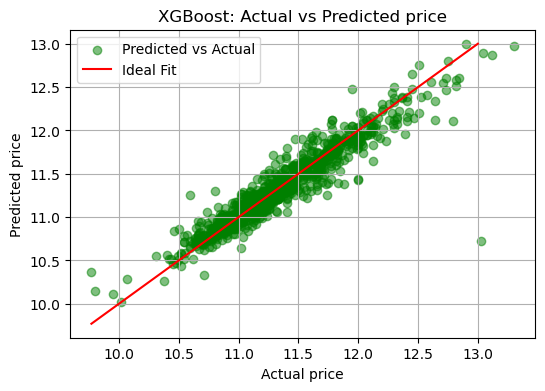

In [14]:
# XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=6, learning_rate=0.1, n_estimators=100)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_val_xgb = xgb_model.predict(X_val)
y_pred_test_xgb = xgb_model.predict(X_test)

# Evaluation
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, mae, rmse, mape

mse_val, mae_val, rmse_val, mape_val = evaluate_model(y_val, y_pred_val_xgb)
print(f'XGBoost Validation - MSE: {mse_val}, MAE: {mae_val}, RMSE: {rmse_val}, MAPE: {mape_val}')

mse_test, mae_test, rmse_test, mape_test = evaluate_model(y_test, y_pred_test_xgb)
print(f'XGBoost Test - MSE: {mse_test}, MAE: {mae_test}, RMSE: {rmse_test}, MAPE: {mape_test}')

plt.figure(figsize=(6, 4))
sns.histplot(y_test, label='target', color='#1859b4', alpha=0.7, bins=40)
sns.histplot(y_pred_test_xgb, label='prediction', color='#b7cde7', alpha=0.8, bins=40)
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('XGBoost: Predictions vs actual distribution')
plt.savefig('figs/xgboost_distribution.png', dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_test_xgb, color='green', alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_pred_test_xgb)], [min(y_test), max(y_pred_test_xgb)], color='red', label='Ideal Fit')  # Diagonal line
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('XGBoost: Actual vs Predicted price')
plt.legend()
plt.grid(True)
plt.savefig('figs/xgboost_plot.png', dpi=300)
plt.show()

CatBoost Validation - MSE: 0.02291667490822255, MAE: 0.11213567767623467, RMSE: 0.15138254492583533, MAPE: 0.9786802084691466
CatBoost Test - MSE: 0.02883067870000636, MAE: 0.11769231939704153, RMSE: 0.1697959914132438, MAPE: 1.0306449862924028


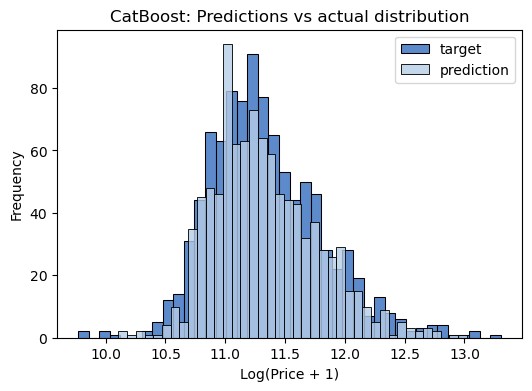

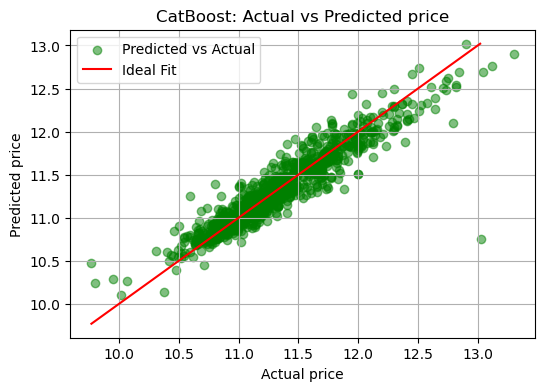

In [15]:
from catboost import CatBoostRegressor

#CatBoost model
cat_model = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE', silent=True)
cat_model.fit(X_train, y_train)


y_pred_val_cat = cat_model.predict(X_val)
y_pred_test_cat = cat_model.predict(X_test)

mse_val, mae_val, rmse_val, mape_val = evaluate_model(y_val, y_pred_val_cat)
print(f'CatBoost Validation - MSE: {mse_val}, MAE: {mae_val}, RMSE: {rmse_val}, MAPE: {mape_val}')

mse_test, mae_test, rmse_test, mape_test = evaluate_model(y_test, y_pred_test_cat)
print(f'CatBoost Test - MSE: {mse_test}, MAE: {mae_test}, RMSE: {rmse_test}, MAPE: {mape_test}')

plt.figure(figsize=(6, 4))
sns.histplot(y_test, label='target', color='#1859b4', alpha=0.7, bins=40)
sns.histplot(y_pred_test_cat, label='prediction', color='#b7cde7', alpha=0.8, bins=40)
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('CatBoost: Predictions vs actual distribution')
plt.savefig('figs/catboost_distribution.png', dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_test_cat, color='green', alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_pred_test_cat)], [min(y_test), max(y_pred_test_cat)], color='red', label='Ideal Fit') 
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('CatBoost: Actual vs Predicted price')
plt.legend()
plt.grid(True)
plt.savefig('figs/catboost_plot.png', dpi=300)
plt.show()


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


ann_model = Sequential()
ann_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1))

ann_model.compile(optimizer='adam', loss='mse')


ann_model.fit(X_train, y_train, epochs=1500, batch_size=32, validation_data=(X_val, y_val), verbose=1)

y_pred_val_ann = ann_model.predict(X_val).flatten()
y_pred_test_ann = ann_model.predict(X_test).flatten()

mse_val, mae_val, rmse_val, mape_val = evaluate_model(y_val, y_pred_val_ann)
print(f'ANN Validation - MSE: {mse_val}, MAE: {mae_val}, RMSE: {rmse_val}, MAPE: {mape_val}')

mse_test, mae_test, rmse_test, mape_test = evaluate_model(y_test, y_pred_test_ann)
print(f'ANN Test - MSE: {mse_test}, MAE: {mae_test}, RMSE: {rmse_test}, MAPE: {mape_test}')


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 55.5698 - val_loss: 0.3984
Epoch 2/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2908 - val_loss: 0.6036
Epoch 3/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2088 - val_loss: 36.9990
Epoch 4/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.2213 - val_loss: 10.4158
Epoch 5/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2787 - val_loss: 0.7766
Epoch 6/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2613 - val_loss: 0.0893
Epoch 7/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1859 - val_loss: 0.1778
Epoch 8/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0899 - val_loss: 0.1365
Epoch 9/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1080 - val_loss: 0.3722
Epoch 10/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2318 - val_loss: 0.5204
Epoch 11/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5041 - val_loss: 1.0496
Epoch 12/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308 - val_loss: 0.0391
Epoch 136/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0325 - val_loss: 0.0359
Epoch 137/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0325 - val_loss: 0.0366
Epoch 138/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0344 - val_loss: 0.0370
Epoch 139/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0315 - val_loss: 0.0369
Epoch 140/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0331 - val_loss: 0.0381
Epoch 141/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0333 - val_loss: 0.0373
Epoch 142/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0361 - val_loss: 0.0430
Epoch 143/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0327 - val_loss: 0.0380
Epoch 144/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0353 - val_loss: 0.0394
Epoch 145/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0358 - val_loss: 0.0362
Epoch 146/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0347 - val_loss: 0.0556
Epoch 270/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0354 - val_loss: 0.0469
Epoch 271/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0338 - val_loss: 0.0382
Epoch 272/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0325 - val_loss: 0.0402
Epoch 273/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311 - val_loss: 0.0379
Epoch 274/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0343 - val_loss: 0.0488
Epoch 275/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0331 - val_loss: 0.0370
Epoch 276/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308 - val_loss: 0.0429
Epoch 277/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0330 - val_loss: 0.0373
Epoch 278/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0314 - val_loss: 0.0435
Epoch 279/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0330 - val_loss: 0.0391
Epoch 280/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0420 - val_loss: 0.0503
Epoch 404/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0318 - val_loss: 0.0523
Epoch 405/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337 - val_loss: 0.0369
Epoch 406/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319 - val_loss: 0.0441
Epoch 407/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0323 - val_loss: 0.0355
Epoch 408/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0286 - val_loss: 0.0354
Epoch 409/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0305 - val_loss: 0.0441
Epoch 410/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0330 - val_loss: 0.0382
Epoch 411/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0302 - val_loss: 0.0432
Epoch 412/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0303 - val_loss: 0.0366
Epoch 413/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0276 - val_loss: 0.0391
Epoch 414/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0299 - val_loss: 0.0374
Epoch 538/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332 - val_loss: 0.0401
Epoch 539/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0328 - val_loss: 0.0348
Epoch 540/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0301 - val_loss: 0.0362
Epoch 541/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0297 - val_loss: 0.0365
Epoch 542/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284 - val_loss: 0.0470
Epoch 543/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337 - val_loss: 0.0426
Epoch 544/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311 - val_loss: 0.0373
Epoch 545/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0280 - val_loss: 0.0379
Epoch 546/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0288 - val_loss: 0.0363
Epoch 547/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0265 - val_loss: 0.0419
Epoch 548/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284 - val_loss: 0.0350
Epoch 672/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265 - val_loss: 0.0354
Epoch 673/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0281 - val_loss: 0.0378
Epoch 674/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264 - val_loss: 0.0426
Epoch 675/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0288 - val_loss: 0.0375
Epoch 676/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0290 - val_loss: 0.0394
Epoch 677/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0295 - val_loss: 0.0394
Epoch 678/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282 - val_loss: 0.0377
Epoch 679/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293 - val_loss: 0.0356
Epoch 680/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274 - val_loss: 0.0376
Epoch 681/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264 - val_loss: 0.0371
Epoch 682/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265 - val_loss: 0.0360
Epoch 806/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0259 - val_loss: 0.0363
Epoch 807/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0261 - val_loss: 0.0353
Epoch 808/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249 - val_loss: 0.0363
Epoch 809/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0237 - val_loss: 0.0376
Epoch 810/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0255 - val_loss: 0.0435
Epoch 811/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0259 - val_loss: 0.0371
Epoch 812/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268 - val_loss: 0.0389
Epoch 813/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265 - val_loss: 0.0387
Epoch 814/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266 - val_loss: 0.0383
Epoch 815/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0256 - val_loss: 0.0359
Epoch 816/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 - val_loss: 0.0359
Epoch 940/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0297 - val_loss: 0.0380
Epoch 941/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0280 - val_loss: 0.0368
Epoch 942/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - val_loss: 0.0367
Epoch 943/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - val_loss: 0.0384
Epoch 944/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244 - val_loss: 0.0361
Epoch 945/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0263 - val_loss: 0.0368
Epoch 946/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0248 - val_loss: 0.0369
Epoch 947/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0269 - val_loss: 0.0441
Epoch 948/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0263 - val_loss: 0.0516
Epoch 949/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291 - val_loss: 0.0688
Epoch 950/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266 - val_loss: 0.0376
Epoch 1073/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271 - val_loss: 0.0365
Epoch 1074/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0247 - val_loss: 0.0357
Epoch 1075/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0290 - val_loss: 0.0376
Epoch 1076/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 - val_loss: 0.0390
Epoch 1077/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251 - val_loss: 0.0364
Epoch 1078/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243 - val_loss: 0.0397
Epoch 1079/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.0454
Epoch 1080/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293 - val_loss: 0.0369
Epoch 1081/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0286 - val_loss: 0.0379
Epoch 1082/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - val_loss: 0.0467
Epoch 1083/1500
92/92 ━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 - val_loss: 0.0367
Epoch 1205/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244 - val_loss: 0.0463
Epoch 1206/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 - val_loss: 0.0412
Epoch 1207/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253 - val_loss: 0.0415
Epoch 1208/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257 - val_loss: 0.0363
Epoch 1209/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 - val_loss: 0.0364
Epoch 1210/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 - val_loss: 0.0398
Epoch 1211/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0255 - val_loss: 0.0361
Epoch 1212/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248 - val_loss: 0.0416
Epoch 1213/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 - val_loss: 0.0444
Epoch 1214/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282 - val_loss: 0.0388
Epoch 1215/1500
92/92 ━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.0430
Epoch 1337/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0261 - val_loss: 0.0415
Epoch 1338/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0229 - val_loss: 0.0399
Epoch 1339/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0260 - val_loss: 0.0355
Epoch 1340/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - val_loss: 0.0363
Epoch 1341/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233 - val_loss: 0.0392
Epoch 1342/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248 - val_loss: 0.0399
Epoch 1343/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258 - val_loss: 0.0396
Epoch 1344/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0259 - val_loss: 0.0364
Epoch 1345/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.0390
Epoch 1346/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264 - val_loss: 0.0379
Epoch 1347/1500
92/92 ━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231 - val_loss: 0.0378
Epoch 1469/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242 - val_loss: 0.0368
Epoch 1470/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253 - val_loss: 0.0373
Epoch 1471/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0257 - val_loss: 0.0375
Epoch 1472/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0257 - val_loss: 0.0376
Epoch 1473/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0252 - val_loss: 0.0460
Epoch 1474/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249 - val_loss: 0.0359
Epoch 1475/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246 - val_loss: 0.0370
Epoch 1476/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - val_loss: 0.0495
Epoch 1477/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258 - val_loss: 0.0409
Epoch 1478/1500
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277 - val_loss: 0.0389
Epoch 1479/1500
92/92 ━━━━━━━━━━━━━━━

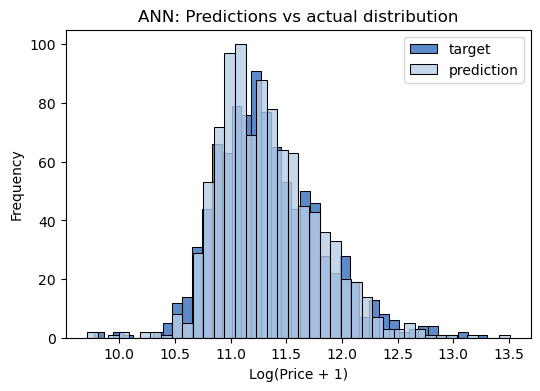

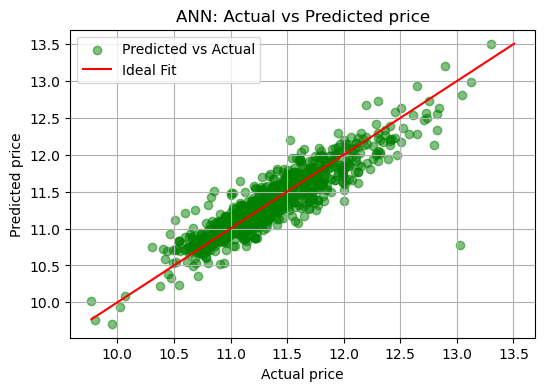

In [17]:

# Plotting
plt.figure(figsize=(6, 4))
sns.histplot(y_test, label='target', color='#1859b4', alpha=0.7, bins=40)
sns.histplot(y_pred_test_ann, label='prediction', color='#b7cde7', alpha=0.8, bins=40)
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('ANN: Predictions vs actual distribution')
plt.savefig('figs/ann_distribution.png', dpi=300)
plt.show()


plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_test_ann, color='green', alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_pred_test_ann)], [min(y_test), max(y_pred_test_ann)], color='red', label='Ideal Fit')  # Diagonal line
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('ANN: Actual vs Predicted price')
plt.legend()
plt.grid(True)
plt.savefig('figs/ann_plot.png', dpi=300)
plt.show()


Random Forest Validation - MSE: 0.031328533414056385, MAE: 0.12884071046622744, RMSE: 0.17699868195570378, MAPE: 1.1256416537440224
Random Forest Test - MSE: 0.03618458365216822, MAE: 0.13426861749009988, RMSE: 0.19022245832752824, MAPE: 1.1751228562736609


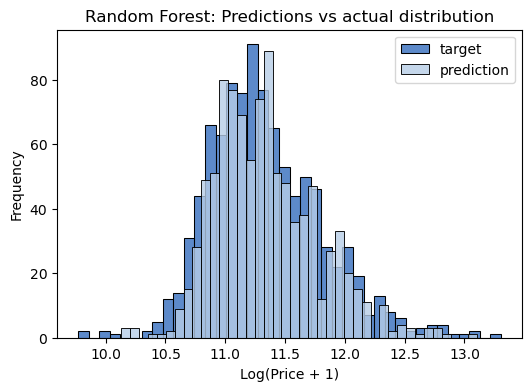

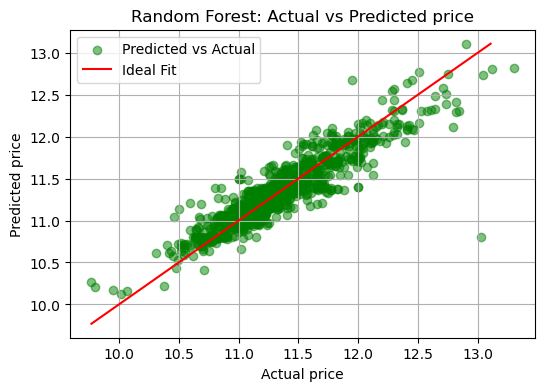

In [18]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=2)
rf_model.fit(X_train, y_train)


y_pred_val_rf = rf_model.predict(X_val)
y_pred_test_rf = rf_model.predict(X_test)


mse_val, mae_val, rmse_val, mape_val = evaluate_model(y_val, y_pred_val_rf)
print(f'Random Forest Validation - MSE: {mse_val}, MAE: {mae_val}, RMSE: {rmse_val}, MAPE: {mape_val}')

mse_test, mae_test, rmse_test, mape_test = evaluate_model(y_test, y_pred_test_rf)
print(f'Random Forest Test - MSE: {mse_test}, MAE: {mae_test}, RMSE: {rmse_test}, MAPE: {mape_test}')


plt.figure(figsize=(6, 4))
sns.histplot(y_test, label='target', color='#1859b4', alpha=0.7, bins=40)
sns.histplot(y_pred_test_rf, label='prediction', color='#b7cde7', alpha=0.8, bins=40)
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Random Forest: Predictions vs actual distribution')
plt.savefig('figs/randforest_distribution.png', dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_test_rf, color='green', alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_pred_test_rf)], [min(y_test), max(y_pred_test_rf)], color='red', label='Ideal Fit')  # Diagonal line
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Random Forest: Actual vs Predicted price')
plt.legend()
plt.grid(True)
plt.savefig('figs/randforest_plot.png', dpi=300)
plt.show()

Gradient Boosting Validation - MSE: 0.019568083622923033, MAE: 0.09980491810056635, RMSE: 0.13988596649744045, MAPE: 0.8727723353015566
Gradient Boosting Test - MSE: 0.02496638132559087, MAE: 0.10275525610946962, RMSE: 0.15800753566077433, MAPE: 0.8987650044087482


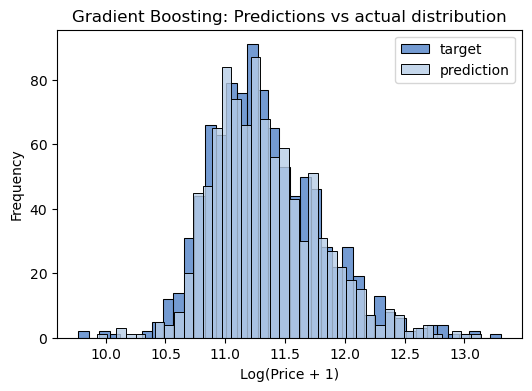

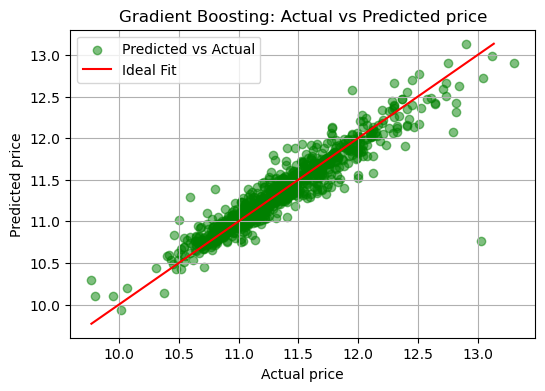

In [19]:
from sklearn.ensemble import GradientBoostingRegressor


gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=2)
gb_model.fit(X_train, y_train)

y_pred_val_gb = gb_model.predict(X_val)
y_pred_test_gb = gb_model.predict(X_test)

mse_val, mae_val, rmse_val, mape_val = evaluate_model(y_val, y_pred_val_gb)
print(f'Gradient Boosting Validation - MSE: {mse_val}, MAE: {mae_val}, RMSE: {rmse_val}, MAPE: {mape_val}')

mse_test, mae_test, rmse_test, mape_test = evaluate_model(y_test, y_pred_test_gb)
print(f'Gradient Boosting Test - MSE: {mse_test}, MAE: {mae_test}, RMSE: {rmse_test}, MAPE: {mape_test}')

plt.figure(figsize=(6, 4))
sns.histplot(y_test, label='target', color='#1859b4', alpha=0.6, bins=40)
sns.histplot(y_pred_test_gb, label='prediction', color='#b7cde7', alpha=0.8, bins=40)
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Gradient Boosting: Predictions vs actual distribution')
plt.savefig('figs/gradboost_distribution.png', dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_test_gb, color='green', alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_pred_test_gb)], [min(y_test), max(y_pred_test_gb)], color='red', label='Ideal Fit')  # Diagonal line
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Gradient Boosting: Actual vs Predicted price')
plt.legend()
plt.grid(True)
plt.savefig('figs/gradboost_plot.png', dpi=300)
plt.show()


Linear Regression Validation - MSE: 0.04245726136099041, MAE: 0.15576860124219793, RMSE: 0.20605159878290294, MAPE: 1.3610764745757473
Linear Regression Test - MSE: 0.048308350640383246, MAE: 0.1575297752703051, RMSE: 0.21979160730196967, MAPE: 1.3770536246994252


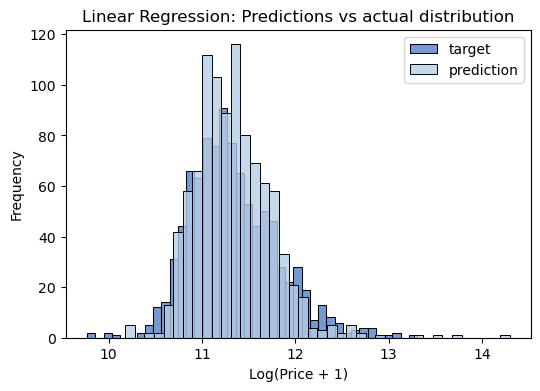

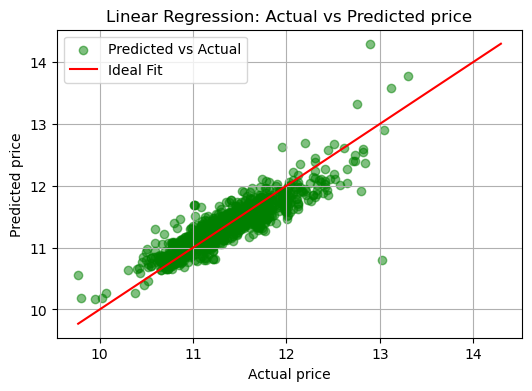

In [20]:
from sklearn.linear_model import LinearRegression


lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_val_lr = lr_model.predict(X_val)
y_pred_test_lr = lr_model.predict(X_test)

mse_val, mae_val, rmse_val, mape_val = evaluate_model(y_val, y_pred_val_lr)
print(f'Linear Regression Validation - MSE: {mse_val}, MAE: {mae_val}, RMSE: {rmse_val}, MAPE: {mape_val}')

mse_test, mae_test, rmse_test, mape_test = evaluate_model(y_test, y_pred_test_lr)
print(f'Linear Regression Test - MSE: {mse_test}, MAE: {mae_test}, RMSE: {rmse_test}, MAPE: {mape_test}')

plt.figure(figsize=(6, 4))
sns.histplot(y_test, label='target', color='#1859b4', alpha=0.6, bins=40)
sns.histplot(y_pred_test_lr, label='prediction', color='#b7cde7', alpha=0.8, bins=40)
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Linear Regression: Predictions vs actual distribution')
plt.savefig('figs/linear_distribution.png', dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_test_lr, color='green', alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_pred_test_lr)], [min(y_test), max(y_pred_test_lr)], color='red', label='Ideal Fit')  # Diagonal line
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Linear Regression: Actual vs Predicted price')
plt.legend()
plt.grid(True)
plt.savefig('figs/linear_plot.png', dpi=300)
plt.show()


Ridge Regression Validation - MSE: 0.042635763261796134, MAE: 0.1559246886728284, RMSE: 0.2064842930147379, MAPE: 1.3626718488593017
Ridge Regression Test - MSE: 0.048205185879786484, MAE: 0.15738322213386743, RMSE: 0.21955679420092306, MAPE: 1.376424631289245


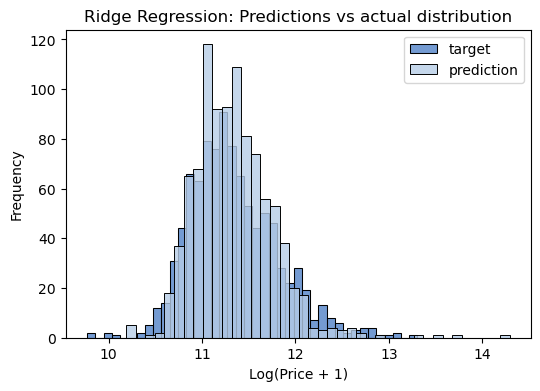

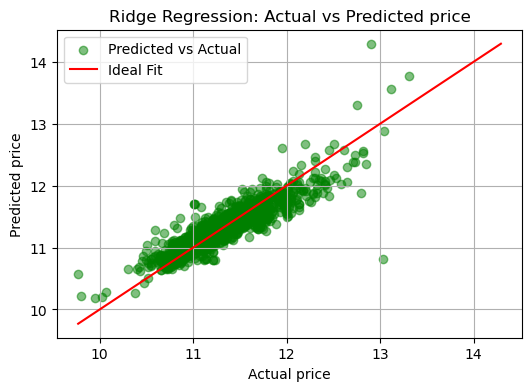

In [22]:
from sklearn.linear_model import Ridge


ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

y_pred_val_ridge = ridge_model.predict(X_val)
y_pred_test_ridge = ridge_model.predict(X_test)

mse_val, mae_val, rmse_val, mape_val = evaluate_model(y_val, y_pred_val_ridge)
print(f'Ridge Regression Validation - MSE: {mse_val}, MAE: {mae_val}, RMSE: {rmse_val}, MAPE: {mape_val}')

mse_test, mae_test, rmse_test, mape_test = evaluate_model(y_test, y_pred_test_ridge)
print(f'Ridge Regression Test - MSE: {mse_test}, MAE: {mae_test}, RMSE: {rmse_test}, MAPE: {mape_test}')

plt.figure(figsize=(6, 4))
sns.histplot(y_test, label='target', color='#1859b4', alpha=0.6, bins=40)
sns.histplot(y_pred_test_ridge, label='prediction', color='#b7cde7', alpha=0.8, bins=40)
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Ridge Regression: Predictions vs actual distribution')
plt.savefig('figs/ridge_regression_predictions_vs_actual_distribution.png', dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_test_ridge, color='green', alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_pred_test_ridge)], [min(y_test), max(y_pred_test_ridge)], color='red', label='Ideal Fit')  # Diagonal line
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Ridge Regression: Actual vs Predicted price')
plt.legend()
plt.grid(True)
plt.savefig('figs/ridge_regression_predictions_vs_actual_plot.png', dpi=300)
plt.show()

In [23]:
models = {
    'Linear Regression': lr_model,
    'Ridge Regression': ridge_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'XGBoost': xgb_model,
    'CatBoost': cat_model,
    'ANN': ann_model
}

results = {}

for name, model in models.items():
    if name == 'ANN':
        y_pred_val = model.predict(X_val).flatten()
        y_pred_test = model.predict(X_test).flatten()
    else:
        y_pred_val = model.predict(X_val)
        y_pred_test = model.predict(X_test)
    
    mse_val, mae_val, rmse_val, mape_val = evaluate_model(y_val, y_pred_val)
    mse_test, mae_test, rmse_test, mape_test = evaluate_model(y_test, y_pred_test)
    
    results[name] = {
        'Validation MSE': mse_val, 'Validation MAE': mae_val, 'Validation RMSE': rmse_val, 'Validation MAPE': mape_val,
        'Test MSE': mse_test, 'Test MAE': mae_test, 'Test RMSE': rmse_test, 'Test MAPE': mape_test
    }

results_df = pd.DataFrame(results).T
print(results_df)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                   Validation MSE  Validation MAE  Validation RMSE  \
Linear Regression        0.042457        0.155769         0.206052   
Ridge Regression         0.042636        0.155925         0.206484   
Random Forest            0.031329        0.128841         0.176999   
Gradient Boosting        0.019568        0.099805         0.139886   
XGBoost                  0.019491        0.101167         0.139610   
CatBoost                 0.022917        0.112136         0.151383   
ANN                      0.036367        0.141770         0.190701   

                   Validation MAPE  Test MSE  Test MAE  Test RMSE  Test MAPE  
Linear Regression         1.361076  0.048308  0.157530   0.219792   1.377054  
Ridge Regression          1.362672  0.048205  0.157383   0.219557   1.376425  
Random Forest             1.125642  0.036185  0.134269   0.190222   1.175123  
Gradient Boosting         0.872772  0.024966 

In [24]:
numeric_columns = df.select_dtypes(include=['number'])

numeric_df = df[numeric_columns.columns]


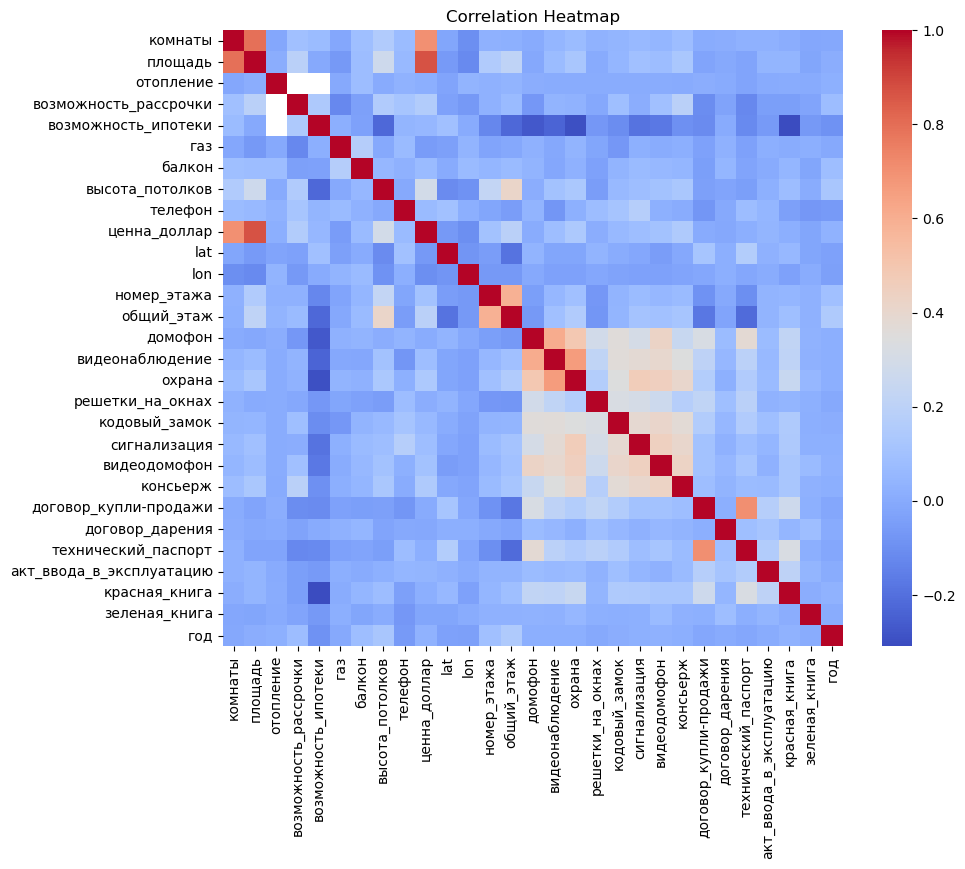

In [67]:
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.savefig('figs/heatmap.png', dpi=300)
plt.show()


In [25]:
import pandas as pd


def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, mae, rmse, mape


models = {
    'Linear Regression': lr_model,
    'Ridge Regression': ridge_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'XGBoost': xgb_model,
    'CatBoost': cat_model,
    'ANN': ann_model
}


best_model_name = None
best_rmse = float('inf')

for name, model in models.items():
    if name == 'ANN':
        y_pred_val = model.predict(X_val).flatten()
    else:
        y_pred_val = model.predict(X_val)
    
    _, _, rmse_val, _ = evaluate_model(y_val, y_pred_val)
    
    if rmse_val < best_rmse:
        best_rmse = rmse_val
        best_model_name = name

best_model = models[best_model_name]


if best_model_name == 'ANN':
    y_pred_test_best = best_model.predict(X_test).flatten()
else:
    y_pred_test_best = best_model.predict(X_test)


y_test_orig_exp = np.expm1(y_test)
y_pred_test_best_exp = np.expm1(y_pred_test_best)


results_df = pd.DataFrame({
    'Actual': y_test_orig_exp,
    'Predicted': y_pred_test_best_exp
})


print("Random 10 rows of Actual and Predicted Prices from the Best Model:")
print(results_df.sample(10))


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Random 10 rows of Actual and Predicted Prices from the Best Model:
       Actual      Predicted
721   49999.0   54764.527344
800  102600.0  100385.757812
614  345000.0  362002.406250
677  129000.0  127596.085938
477  220000.0  269662.843750
875  155000.0  170850.765625
74    49500.0   48969.019531
208   93500.0   85915.210938
937  165000.0  142849.453125
393   72700.0   65278.132812


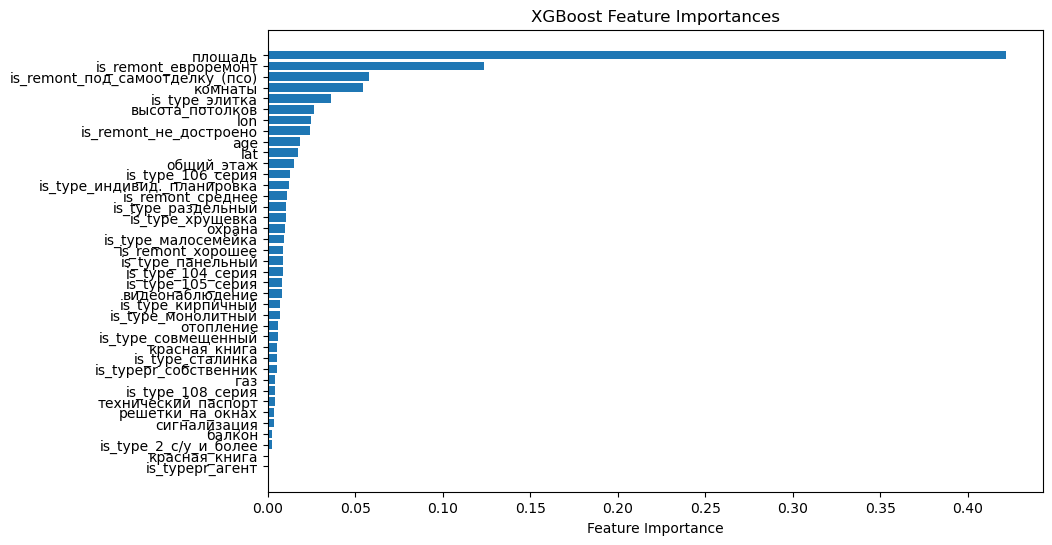

In [42]:
importances = {}

#importances['Random Forest'] = rf_model.feature_importances_
#importances['Gradient Boosting'] = gb_model.feature_importances_

importances['XGBoost'] = xgb_model.feature_importances_
#importances['CatBoost'] = cat_model.get_feature_importance()

feature_names = base + [
    'age', 'общий_этаж', 'lat', 'lon', 'красная_книга', 'охрана', 'балкон', 'газ', 'видеонаблюдение',
    'решетки_на_окнах', 'сигнализация', 'технический_паспорт', 'is_type_монолитный', 'is_type_кирпичный',
    'is_type_панельный', 'is_type_раздельный', 'is_type_совмещенный', 'is_type_2_с/у_и_более',
    'is_type_элитка', 'is_type_индивид._планировка', 'is_type_105_серия', 'is_type_106_серия', 'is_type_104_серия',
    'is_type_хрущевка', 'is_type_108_серия', 'is_type_сталинка', 'is_type_малосемейка', 'is_typepr_собственник',
    'is_typepr_агент', 'is_remont_евроремонт', 'is_remont_под_самоотделку_(псо)', 'is_remont_хорошее',
    'is_remont_среднее', 'is_remont_не_достроено'
]

for model_name, feature_importance in importances.items():
    sorted_idx = np.argsort(feature_importance)[::-1]
    sorted_feature_importance = feature_importance[sorted_idx]
    sorted_features = [feature_names[i] for i in sorted_idx]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
    plt.yticks(range(len(sorted_feature_importance)), sorted_features)
    plt.gca().invert_yaxis()
    plt.xlabel('Feature Importance')
    plt.title(f'{model_name} Feature Importances')
    plt.savefig('figs/feature_imp_xgboost.png', dpi=300, bbox_inches='tight')
    plt.show()


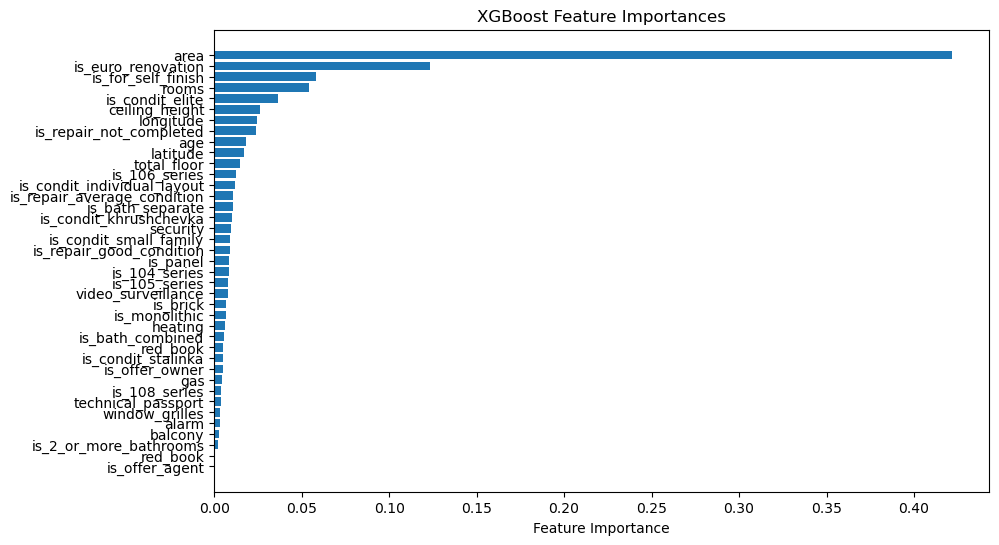

In [45]:

translation_dict = {
    'комнаты': 'rooms', 'площадь': 'area', 'отопление': 'heating', 'высота_потолков': 'ceiling_height', 'красная_книга': 'red_book',
    'age': 'age', 'общий_этаж': 'total_floor', 'lat': 'latitude', 'lon': 'longitude', 'красная_книга': 'red_book', 'охрана': 'security',
    'балкон': 'balcony', 'газ': 'gas', 'видеонаблюдение': 'video_surveillance', 'решетки_на_окнах': 'window_grilles', 'сигнализация': 'alarm',
    'технический_паспорт': 'technical_passport', 'is_type_монолитный': 'is_monolithic', 'is_type_кирпичный': 'is_brick',
    'is_type_панельный': 'is_panel', 'is_type_раздельный': 'is_bath_separate', 'is_type_совмещенный': 'is_bath_combined', 'is_type_2_с/у_и_более': 'is_2_or_more_bathrooms',
    'is_type_элитка': 'is_condit_elite', 'is_type_индивид._планировка': 'is_condit_individual_layout', 'is_type_105_серия': 'is_105_series', 'is_type_106_серия': 'is_106_series',
    'is_type_104_серия': 'is_104_series', 'is_type_хрущевка': 'is_condit_khrushchevka', 'is_type_108_серия': 'is_108_series', 'is_type_сталинка': 'is_condit_stalinka',
    'is_type_малосемейка': 'is_condit_small_family', 'is_typepr_собственник': 'is_offer_owner', 'is_typepr_агент': 'is_offer_agent', 'is_remont_евроремонт': 'is_euro_renovation',
    'is_remont_под_самоотделку_(псо)': 'is_for_self_finish', 'is_remont_хорошее': 'is_repair_good_condition', 'is_remont_среднее': 'is_repair_average_condition',
    'is_remont_не_достроено': 'is_repair_not_completed'
}


translated_feature_names = [translation_dict[feature_name] for feature_name in feature_names]


for model_name, feature_importance in importances.items():
  
    sorted_idx = np.argsort(feature_importance)[::-1]
    sorted_feature_importance = feature_importance[sorted_idx]
    sorted_features = [translated_feature_names[i] for i in sorted_idx]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
    plt.yticks(range(len(sorted_feature_importance)), sorted_features)
    plt.gca().invert_yaxis()
    plt.xlabel('Feature Importance')
    plt.title(f'{model_name} Feature Importances')
    plt.savefig('figs/feature_imp_xgboost.png', dpi=300, bbox_inches='tight')
    plt.show()
